# Delay, gain, and mix

The term **convolution** gets thrown around quite a bit in signal processing, and it can sound more complicated than it really is.
In the simplest terms, convolution consists of three basic operations:

1. **delaying** a signal by some fixed number of samples,
2. applying a **gain** to the delayed signal (changing its amplitude),
3. **mixing** (adding) the delayed and gained signal with the original signal.

Before we get into the equations in full generality, let's work through a couple of simple examples.

In [2]:
import numpy as np
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.path as path
import matplotlib.patches as patches
from matplotlib.transforms import Bbox
import warnings
warnings.simplefilter('ignore')

from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('bauhaus')

np.random.seed(20200101)

colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

def figaspect(arg):
    # min/max sizes to respect when autoscaling.  If John likes the idea, they
    # could become rc parameters, for now they're hardwired.
    figsize_min = np.array((4.0, 2.0))  # min length for width/height
    figsize_max = np.array((16.0, 16.0))  # max length for width/height

    # Extract the aspect ratio of the array
    isarray = hasattr(arg, 'shape') and not np.isscalar(arg)
    if isarray:
        nr, nc = arg.shape[:2]
        arr_ratio = nr / nc
    else:
        arr_ratio = arg

    # Height of user figure defaults
    fig_width = matplotlib.rcParams['figure.figsize'][0]

    # New size for the figure, keeping the aspect ratio of the caller
    newsize = np.array((fig_width, fig_width *arr_ratio))
    #newsize = np.array((fig_height / arr_ratio, fig_height))

    # Sanity checks, don't drop either dimension below figsize_min
    newsize /= min(1.0, *(newsize / figsize_min))

    # Avoid humongous windows as well
    newsize /= max(1.0, *(newsize / figsize_max))

    # Finally, if we have a really funky aspect ratio, break it but respect
    # the min/max dimensions (we don't want figures 10 feet tall!)
    newsize = np.clip(newsize, figsize_min, figsize_max)
    return newsize

## Example 1: delay and mix

$$
\require{cancel}\notag%
\require{color}\notag%
$$

As a first example, let's consider the case where there is no gain applied to either the delayed or original signal, so we only have to worry about delay and mixing.
If our input signal is $x[n]$, and our delay is $k>0$ samples, the output of this process will be a new signal $y[n]$ defined as

As a general convention, we use $x[n]$ to denote an "input" signal, and $y[n]$ to denote an "output" signal, meaning the result of some computational process applied to $x[n]$.

$$
y[n] = x[n] + x[n-k].
$$

That is, the $n$th output sample $y[n]$ is the sum of the input sample $x[n]$ and the input sample $k$ steps back in time $x[n-k]$.

The figure below demonstrates this process for an input $x[n]$ generated by a square wave, and a delay of $k=3$ samples.

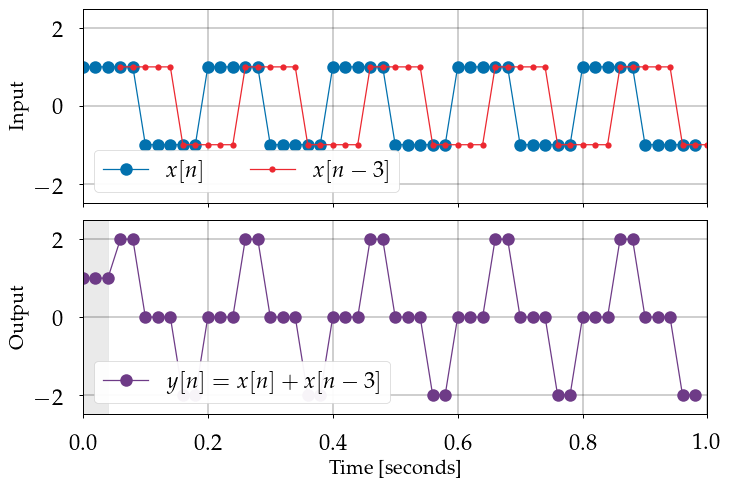

In [7]:
# Make an array of samples with a square wave
fs = 50
k = 3
times = np.arange(fs) / fs
x = scipy.signal.square(2 * np.pi * 5 * times)
h = np.zeros(k+1)
h[0] = 1
h[k] = 1

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=figaspect(2./3))
ax.plot(times, x, label=r'$x[n]$', linewidth=1, marker='o', markersize=10)
ax.plot(times + k/fs, x, label='$x[n-{}]$'.format(k), color=colors[1],
          linewidth=1, marker='.', markersize=10)
ax.legend(ncol=2, loc='lower left')
ax.set_ylabel('Input')
ax.label_outer()

y = np.convolve(x, h, mode='full')[:len(x)]

ax2.plot(times, y, label='$y[n] = x[n] + x[n-{}]$'.format(k),
           linewidth=1, marker='o', markersize=10, color=colors[4])
ax2.axvspan(0, (k-1) / fs, alpha=0.1, zorder=-1, color=colors[3])
ax2.set_xlabel('Time [seconds]')
ax2.label_outer()
ax2.set_xlim([0, 1])
ax2.set_ylim([-2.5, 2.5])

ax2.set_ylabel('Output')
ax2.legend(ncol=2, loc='lower left');

Before we move on, there are already a couple of observations we can make.

First, the output $y[n]$ looks very different from the input $x[n]$.
Wherever both $x[n]$ and $x[n-3]$ are both positive (or negative), $y[n]$ becomes larger (or smaller), reaching a peak amplitude of 2.
When $x[n]$ and $x[n-3]$ have opposite signs, they cancel each-other out, resulting in $y[n]=0$ (e.g., at 0.2 seconds).
Overall, the resulting $y$ signal has a different shape than the input $x$, more akin to a triangle wave than the square wave we started with.
Different delays will produce different shapes, which we will perceive as changes in timbre.

Second, the first few samples of $y[n]$ (in the shaded region) look different from the rest of the signal: these are the only places where the value of $1$ (rather than $-2, 0, 2$) occur.
To understand this, we need to investigate the equation for $y$ more carefully, and think about what happens when $n < k$.
If $n< k$, then $n-k < 0$, so the sample index $n-k$ corresponds to a *negative* time index.
As stated in [chapter 1](/ch01/Preliminaries.html#Standard-conventions), we generally assume that a signal is silent for negative time indicies (i.e., before recording started).
So for the first few samples, we'll have

$$
y[n] = x[n] + {\color{red}\cancel{x[n-k]}} \quad \text{ if } n < k.
$$

This period of time corresponding to $n<k$ is sometimes referred to as the *warm-up* phase, where the filter we're applying has not yet seen enough of the input signal to operate completely.

Having defined the behavior for the warm-up phase, we can now translate the equation for $y[n]$ into code as follows:

```python
# Make an output buffer the same size as the input
N = len(x)
y = np.zeros(N)

# Set our delay
k = 4

for n in range(N):
    if n >= k:
        y[n] = x[n] + x[n-k]
    else:
        y[n] = x[n]
```

A more complete code example is given below.

In [6]:
import numpy as np
import scipy.signal
from IPython.display import Audio

# Our input will be a 100Hz square wave for one second, sampled at 8 KHz.
fs = 8000
duration = 1
f0 = 100

times = np.arange(duration * fs) / fs
x = scipy.signal.square(2 * np.pi * f0 * times)

# The delay will be 8 samples to start with.
k = 8

# Try changing k to see how it affects the sound of the output.
# Can you find a setting of k that makes the output silent?

# Initialize the output buffer to match the shape of x
N = len(x)
y = np.zeros(N)

# Compute y
for n in range(N):
    if n >= k:
        y[n] = x[n] + x[n-k]
    else:
        # At the start of the signal, x[n-k] doesn't exist yet
        # so pretend that x[n-k] = 0
        y[n] = x[n]
        

display('Input x[n]')
display(Audio(data=x, rate=fs))

display('Output y[n] = x[n] + x[n-{}]'.format(k))
display(Audio(data=y, rate=fs))

'Input x[n]'

'Output y[n] = x[n] + x[n-8]'

## Example 2: delay + gain

In this example, we'll mix together three different delays with different *gain* coefficients:

$$
y[n] = \frac{1}{2} x[n] - \frac{1}{2} x[n-1].
$$

Here, the delay-0 signal ($x[n]$) has a gain of $+1/2$, and the delay-1 signal ($x[n-1]$) has gain $-1/2$.
Intuitively, whenever the input signal is not changing (i.e., $x[n] = x[n-1]$), then the output signal $y[n]$ should be zero.
Whenever the signal is changing, the output shows the direction of the change:

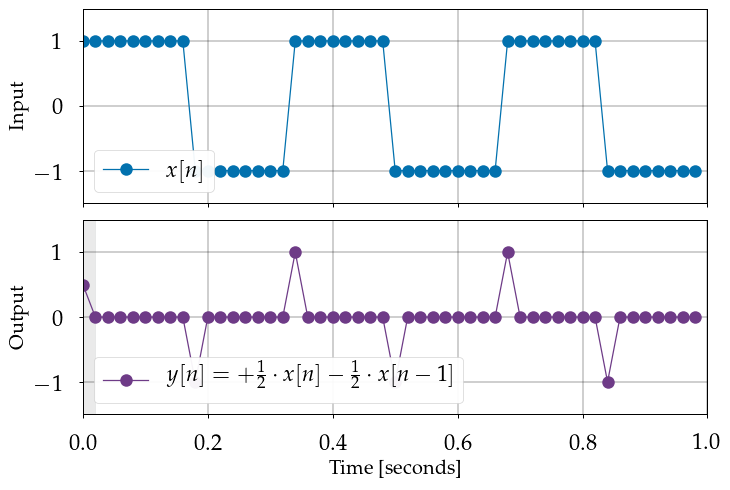

In [9]:
# Make an array of samples with a square wave
fs = 50

times = np.arange(fs) / fs
x = scipy.signal.square(2 * np.pi * 3 * times)

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=figaspect(2./3))
ax.plot(times, x, label=r'$x[n]$', linewidth=1, marker='o', markersize=10)
ax.legend(ncol=2, loc='lower left')
ax.label_outer()
ax.set_ylabel('Input')

y = np.convolve(x, [+0.5, -0.5], mode='full')[:len(x)]

ax2.plot(times, y, label=r'$y[n] = +\frac{1}{2}\cdot x[n] - \frac{1}{2}\cdot x[n-1]$',
           linewidth=1, marker='o', markersize=10, color=colors[4])
ax2.axvspan(0, 1 / fs, alpha=0.1, zorder=-1, color=colors[3])
ax2.set_xlabel('Time [seconds]')
ax2.label_outer()
ax2.set_xlim([0, 1])
ax2.set_ylim([-1.5, 1.5])
ax2.set_ylabel('Output')
ax2.legend(ncol=2, loc='lower left');

Note that in this example, the gain coefficients can be both positive **or negative**.

The code below implements filter on the same square wave as the previous example.
Try modifying the gain coefficients below.
How does the sound change if you make both coefficients positive?  Or both negative?

In [26]:
import numpy as np
import scipy.signal
from IPython.display import Audio

# Our input will be a 100Hz square wave for one second, sampled at 8 KHz.
fs = 8000
duration = 1
f0 = 100

times = np.arange(duration * fs) / fs
x = scipy.signal.square(2 * np.pi * f0 * times)

# Initialize the output buffer to match the shape of x
N = len(x)
y = np.zeros(N)

# Compute y
for n in range(N):
    if n >= 1:
        y[n] = 0.5 * x[n] - 0.5 * x[n-1]
    else:
        # At the start of the signal, x[n-1] doesn't exist yet
        # so pretend that x[n-k] = 0
        y[n] = x[n]
        

display('Input x[n]')
display(Audio(data=x, rate=fs))

display('Output y[n] = 1/2 * x[n] - 1/2 * x[n-1]')
display(Audio(data=y, rate=fs))

'Input x[n]'

'Output y[n] = 1/2 * x[n] - 1/2 * x[n-1]'